<a href="https://colab.research.google.com/github/PKKarna/Econometrics_basic/blob/main/BalanceSheetOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimal Weights: [2.00308613e-15 0.00000000e+00 1.00000000e+00]
Expected Return: 0.03727604747587623


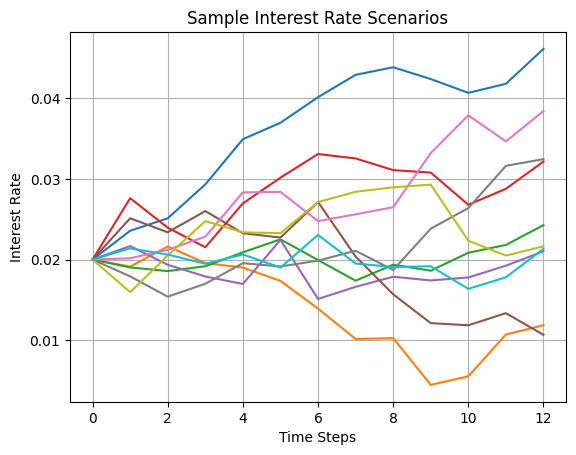

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ----------------------------
# 1. Vasicek Model
# ----------------------------
def vasicek_model(r0, kappa, theta, sigma, dt, steps):
    rates = [r0]
    for _ in range(steps):
        dr = kappa * (theta - rates[-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates.append(rates[-1] + dr)
    return np.array(rates)

# ----------------------------
# 2. Generate Scenarios
# ----------------------------
def generate_scenarios(n_paths, time_horizon, dt, model_func, *model_args):
    steps = int(time_horizon / dt)
    all_scenarios = np.zeros((n_paths, steps + 1))
    for i in range(n_paths):
        all_scenarios[i] = model_func(*model_args, dt, steps)
    return all_scenarios

# ----------------------------
# 3. Objective Function
# ----------------------------
def objective_function(weights, scenario_matrix):
    returns = scenario_matrix @ weights
    expected_return = np.mean(returns)
    risk_penalty = np.std(returns) * 0.5  # adjustable
    return -(expected_return - risk_penalty)

# ----------------------------
# 4. Setup Simulation
# ----------------------------
n_assets = 3
initial_weights = np.ones(n_assets) / n_assets
bounds = [(0, 1) for _ in range(n_assets)]
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

r0 = 0.02
kappa = 0.15
theta = 0.03
sigma = 0.01
dt = 1/12  # Monthly steps
time_horizon = 1  # 1 year
n_paths = 1000

# Simulate interest rate scenarios
scenarios = generate_scenarios(n_paths, time_horizon, dt, vasicek_model, r0, kappa, theta, sigma)

# Create dummy scenario matrix for 3 assets
# Assume asset returns are some function of the interest rate paths
scenario_matrix = np.column_stack([
    -0.5 * scenarios[:, -1],
    0.2 * scenarios[:, -1] + 0.03,
    np.random.normal(0.04, 0.005, n_paths)
])

# ----------------------------
# 5. Optimization
# ----------------------------
result = minimize(objective_function, initial_weights,
                  args=(scenario_matrix,),
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints)

# ----------------------------
# 6. Output Results
# ----------------------------
print("Optimal Weights:", result.x)
print("Expected Return:", -result.fun)

# Plot interest rate path sample
plt.plot(scenarios[:10].T)
plt.title("Sample Interest Rate Scenarios")
plt.xlabel("Time Steps")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()


Optimal Weights: [7.00514032e-16 2.00000000e-01 7.50000000e-01 5.25000000e-01
 4.75000000e-01 5.00000000e-02]
Expected NII: 0.013687134228599181
Breakdown:
Asset Allocation (Loans, Bonds, Other): [7.00514032e-16 2.00000000e-01 7.50000000e-01]
Deposits: 0.5249999999999991
Wholesale Funding: 0.47500000000000075
Liquidity Reserve: 0.04999999999999985


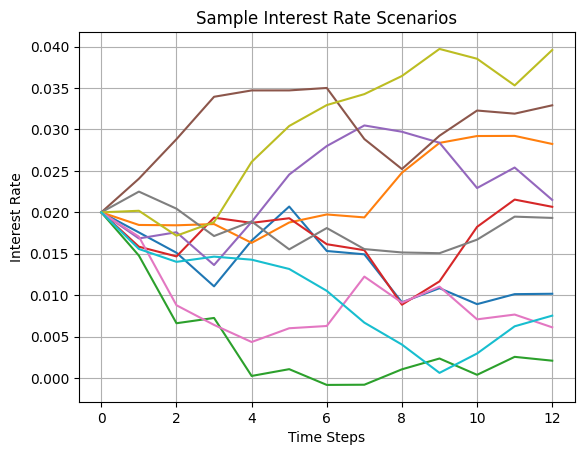

In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ----------------------------
# 1. Vasicek Model
# ----------------------------
def vasicek_model(r0, kappa, theta, sigma, dt, steps):
    rates = [r0]
    for _ in range(steps):
        dr = kappa * (theta - rates[-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates.append(rates[-1] + dr)
    return np.array(rates)

# ----------------------------
# 2. Generate Scenarios
# ----------------------------
def generate_scenarios(n_paths, time_horizon, dt, model_func, *model_args):
    steps = int(time_horizon / dt)
    all_scenarios = np.zeros((n_paths, steps + 1))
    for i in range(n_paths):
        all_scenarios[i] = model_func(*model_args, dt, steps)
    return all_scenarios

# ----------------------------
# 3. Objective Function - Maximize Expected Net Interest Income (NII)
# ----------------------------
def objective_function(weights, asset_rates, liability_rates):
    asset_allocation = weights[:3]
    deposits = weights[3]
    wholesale = weights[4]
    liquidity_reserve = weights[5]

    # Normalize allocations
    total_assets = np.sum(asset_allocation) + liquidity_reserve
    total_liabilities = deposits + wholesale

    asset_income = asset_rates @ asset_allocation
    liability_cost = np.mean(liability_rates) * (deposits + wholesale)
    liquidity_cost = 0.01 * liquidity_reserve  # assume low yield

    nii = asset_income - liability_cost - liquidity_cost
    expected_nii = np.mean(nii)
    return -expected_nii  # negative for maximization

# ----------------------------
# 4. Setup Simulation
# ----------------------------
n_assets = 3
initial_weights = np.array([0.2, 0.2, 0.2, 0.2, 0.15, 0.05])  # 3 assets, deposits, wholesale, liquidity
bounds = [(0, 1) for _ in initial_weights]
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x[:3]) + x[5] - 1},  # total asset side = 1
    {'type': 'eq', 'fun': lambda x: x[3] + x[4] - 1},           # total liability side = 1
    {'type': 'ineq', 'fun': lambda x: x[3] - 0.3},              # minimum deposit funding (LCR proxy)
    {'type': 'ineq', 'fun': lambda x: x[5] - 0.05},             # minimum liquidity reserve
    {'type': 'ineq', 'fun': lambda x: x[0] + x[1] - 0.2}        # minimum core lending (NSFR proxy)
]

r0 = 0.02
kappa = 0.15
theta = 0.03
sigma = 0.01
dt = 1/12  # Monthly steps
time_horizon = 1  # 1 year
n_paths = 1000

# Simulate interest rate scenarios
scenarios = generate_scenarios(n_paths, time_horizon, dt, vasicek_model, r0, kappa, theta, sigma)

# Create synthetic asset rates based on scenarios
asset_rates = np.column_stack([
    0.01 + 0.5 * scenarios[:, -1],
    0.015 + 0.4 * scenarios[:, -1],
    0.02 + 0.3 * scenarios[:, -1]
])

# Synthetic liability rates (e.g., deposit and wholesale funding)
liability_rates = 0.005 + 0.25 * scenarios[:, -1]  # deposit beta effect

# ----------------------------
# 5. Optimization
# ----------------------------
result = minimize(objective_function, initial_weights,
                  args=(asset_rates, liability_rates),
                  method='SLSQP',
                  bounds=bounds,
                  constraints=constraints)

# ----------------------------
# 6. Output Results
# ----------------------------
print("Optimal Weights:", result.x)
print("Expected NII:", -result.fun)
print("Breakdown:")
print("Asset Allocation (Loans, Bonds, Other):", result.x[:3])
print("Deposits:", result.x[3])
print("Wholesale Funding:", result.x[4])
print("Liquidity Reserve:", result.x[5])

# Plot interest rate path sample
plt.plot(scenarios[:10].T)
plt.title("Sample Interest Rate Scenarios")
plt.xlabel("Time Steps")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.show()
